## Load and preprocess data

In [1]:
import numpy as np
import pandas as pd

data = np.loadtxt('data/train1.dat', unpack = True)
print(data.shape)

columns = ["CO+CO2", "N2"] + ["n2_out"+ f"{v}" for v in range(1, 50)] + ["CO", "CO2", "T"]

df_all = pd.DataFrame(data=data.transpose(), index=None, columns=columns)
df_all.describe()

(54, 52326)


,CO+CO2,N2,n2_out1,n2_out2,n2_out3,n2_out4,n2_out5,n2_out6,n2_out7,n2_out8,...,n2_out43,n2_out44,n2_out45,n2_out46,n2_out47,n2_out48,n2_out49,CO,CO2,T
count,5.232600e+04,52326.000000,5.232600e+04,5.232600e+04,5.232600e+04,52326.000000,5.232600e+04,5.232600e+04,52326.000000,5.232600e+04,...,5.232600e+04,5.232600e+04,5.232600e+04,5.232600e+04,5.232600e+04,5.232600e+04,5.232600e+04,5.232600e+04,52326.000000,52326.000000
mean,8.653069e-02,0.723048,1.219701e-03,6.250134e-05,3.528598e-04,0.095353,1.321332e-03,7.167347e-02,0.000015,1.818782e-06,...,6.103185e-09,6.598413e-07,1.096263e-08,5.729088e-09,1.902802e-06,8.208105e-08,3.443573e-06,1.897905e+00,7.638674,1365.160495
std,5.863576e-02,0.011742,1.549976e-03,8.876846e-05,5.164918e-04,0.083963,1.589965e-03,4.762637e-02,0.000026,3.703384e-06,...,1.332074e-08,1.295217e-06,2.967881e-08,1.778710e-08,4.000970e-06,2.118679e-07,6.825974e-06,1.968858e+01,17.831131,685.382086
min,1.277487e-09,0.703300,1.512701e-15,0.000000e+00,3.952593e-16,0.000018,2.700118e-13,1.045357e-09,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.031275e+01,-0.057781,300.000019
25%,1.958098e-02,0.712806,7.037527e-05,3.335854e-10,1.983309e-09,0.013695,7.075132e-08,1.742058e-02,0.000001,1.304035e-07,...,7.737326e-12,8.695029e-10,1.231349e-11,0.000000e+00,0.000000e+00,0.000000e+00,4.920349e-15,-1.563100e+00,0.001537,584.141121
50%,1.028809e-01,0.722855,4.580965e-04,1.401952e-05,3.090007e-05,0.071667,3.230322e-04,8.588778e-02,0.000004,2.875641e-07,...,1.479334e-10,3.203315e-08,2.103784e-10,4.581518e-12,1.681007e-09,1.784835e-12,2.981749e-08,-1.481663e-11,1.240181,1687.538899
75%,1.414604e-01,0.733174,1.878147e-03,1.045078e-04,6.024323e-04,0.190535,2.686276e-03,1.168516e-01,0.000015,1.586186e-06,...,3.755820e-09,6.578606e-07,5.291744e-09,2.435198e-09,1.316647e-06,1.319463e-08,3.361497e-06,1.284304e-02,5.071690,1970.561378
max,1.604542e-01,0.743573,5.590135e-03,3.696017e-04,2.288594e-03,0.225883,5.042992e-03,1.276514e-01,0.000156,2.603021e-05,...,6.656466e-08,7.424717e-06,2.198631e-07,1.715413e-07,1.781211e-05,1.471155e-06,3.734359e-05,1.775826e+02,120.161490,2124.990919


In [2]:
df_all_norm = (df_all-df_all.min())/(df_all.max()-df_all.min())  # min-max norm
df_all_norm.to_pickle("data/train1_norm.pkl")

min_max = {'min': df_all.min(), 'max': df_all.max()}
df_min_max = pd.DataFrame(min_max)
df_min_max.to_pickle("data/train1_min_max.pkl")

## Resample important area
For area with y >0.8, resample `n_copy` times.

In [3]:
resample = df_all_norm[(df_all_norm["CO"] > 0.8) | (df_all_norm["CO2"] > 0.8)]
df_all_norm_resampled = df_all_norm.copy()
n_copy = 10
for c in range(n_copy):
    df_all_norm_resampled = df_all_norm_resampled.append(resample.copy())

df_all_norm_resampled.to_pickle("data/train1_norm_resampled.pkl")

## Reload data

In [4]:
import pandas as pd

df_min_max = pd.read_pickle("data/train1_min_max.pkl")  # to construct true err
df_all_norm = pd.read_pickle("data/train1_norm_resampled.pkl")  # reload resampled

In [5]:
import torch
from torch.autograd import Variable

x = df_all_norm[["CO+CO2", "N2"]]
y = df_all_norm[["CO", "CO2"]]

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

x = torch.tensor(x.values, device=device)
y = torch.tensor(y.values, device=device)

device = cuda:1


In [6]:
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline


def plot_3d_subplot(x, y, savepath):
    '''
     x,y type: numpy 2darray
    '''
    fig = plt.figure(figsize=(20, 10))
    xline, yline, zline1, zline2 = x[:, 0], x[:, 1], y[:, 0], y[:, 1]

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_xlabel('CO+CO2', fontsize=10)
    ax1.set_ylabel('N2', fontsize=10)
    ax1.set_zlabel('CO', fontsize=10)
    ax1.scatter3D(xline, yline, zline1, c=zline1, cmap=cm.coolwarm)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_xlabel('CO+CO2', fontsize=10)
    ax2.set_ylabel('N2', fontsize=10)
    ax2.set_zlabel('CO2', fontsize=10)
    ax2.scatter3D(xline, yline, zline2, c=zline2, cmap=cm.coolwarm)

    plt.savefig(savepath)

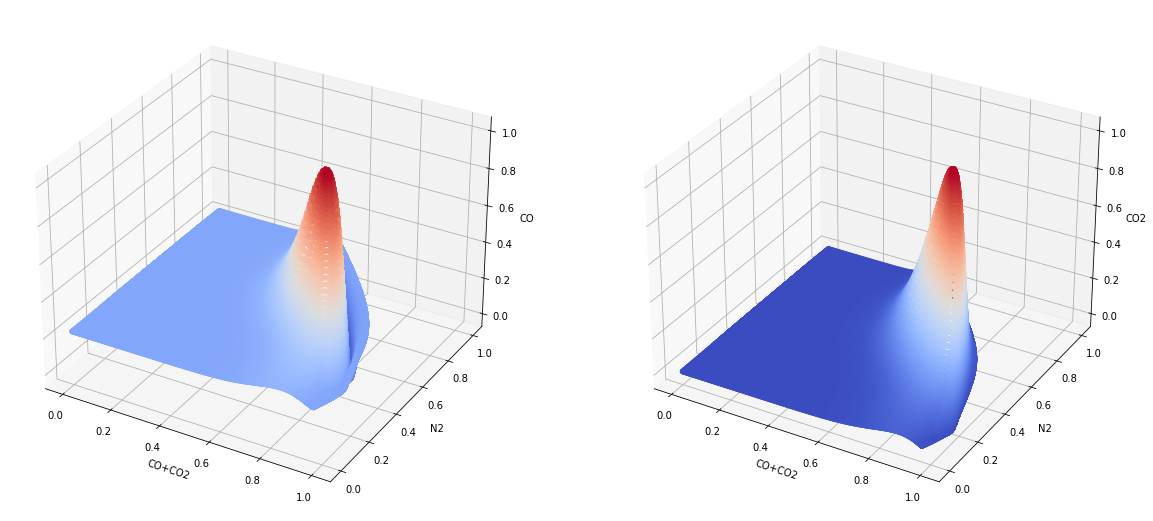

In [7]:
plot_3d_subplot(x[:, :2].cpu().data.numpy(), y.cpu().data.numpy(), f"result/3D_plot-ann1-CO_CO2-target.png")

# Model training

In [8]:
import torch.utils.data as Data

torch.manual_seed(1)    # reproducible

BATCH_SIZE = 64  # x.shape[0]

flame_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=flame_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False, )

## Define model

In [24]:
EPOCH = 500  # 500
lr = 0.01
decayRate = 0.96
token = f"epoch={EPOCH}-lr={lr:.3f}-decay={decayRate:.2f}"

In [25]:
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from torch import Tensor

class FlameLoss(_Loss):
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'sum') -> None:
        super(FlameLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return torch.sum((target + 1) * (input - target) ** 2)

Start time = 2021-11-19 22:13:17.033083
End time = 2021-11-19 22:31:31.485718
Final MSEloss=0.07313168048858643


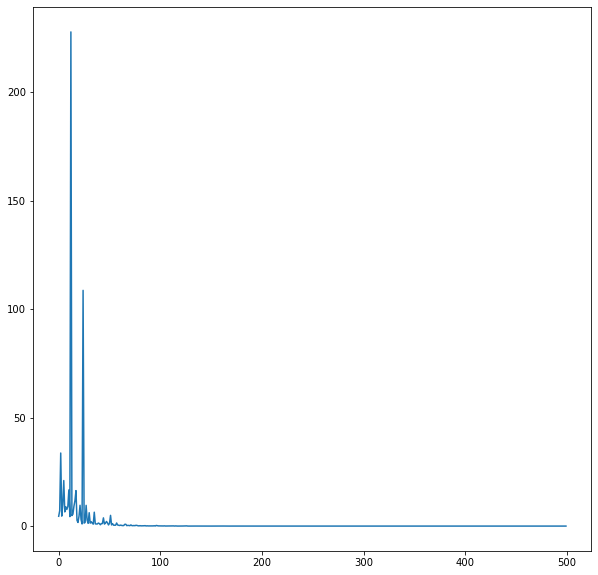

In [26]:
import imageio
from mpl_toolkits import mplot3d
import datetime
import numpy as np

net = torch.nn.Sequential(
        torch.nn.Linear(2, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 2),
    ).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, decayRate)  # lr*gamma^step

loss_values = []

print(f"Start time = {datetime.datetime.now()}")

for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        b_x = Variable(batch_x).to(device)
        b_y = Variable(batch_y).to(device)

        y_pred = net(b_x.float())
        loss = FlameLoss()(y_pred, b_y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate model:
    net.eval()
    with torch.no_grad():
        y_pred = net(x.float())
        mseLoss = torch.nn.MSELoss(reduction='sum')(y_pred, y.float())
        loss_values.append(mseLoss.cpu())

    # enable training
    net.train()
    lr_decay.step()

print(f"End time = {datetime.datetime.now()}")
print(f"Final MSEloss={mseLoss}")

fig = plt.figure(figsize=(10, 10))
plt.plot(loss_values)
plt.savefig(f"result/3D_plot-ann1-CO_CO2-train-{token}-loss={mseLoss:.6f}.png")
np.savetxt(f"result/3D_plot-ann1-CO_CO2-train-{token}-loss={mseLoss:.6f}.csv", loss_values, delimiter =", ", fmt='%s')

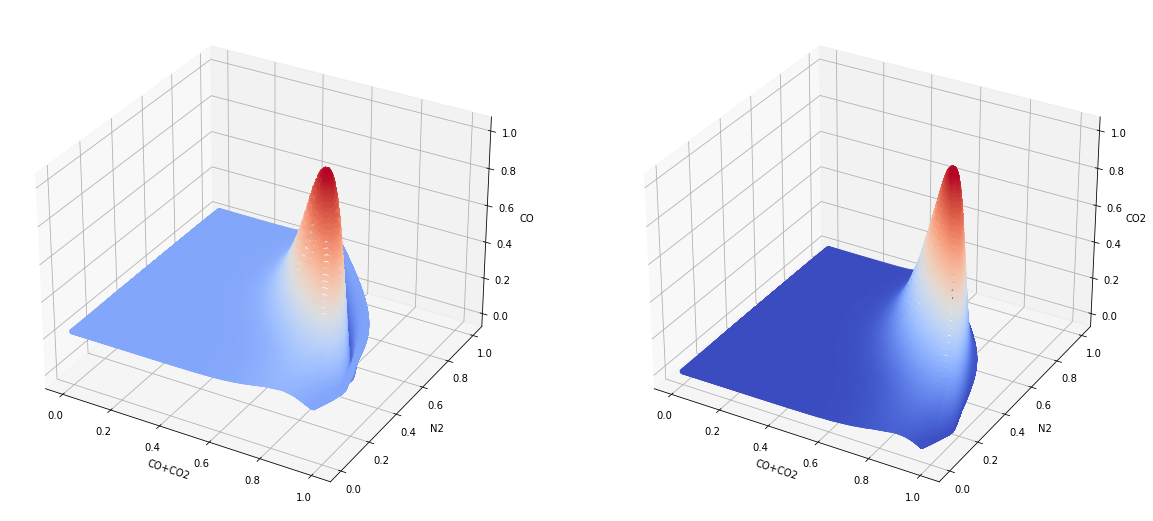

In [27]:
plot_3d_subplot(x[:, :2].cpu().data.numpy(), y_pred.cpu().data.numpy(), f"result/3D_plot-ann1-CO_CO2-{token}-loss={mseLoss:.6f}.png")

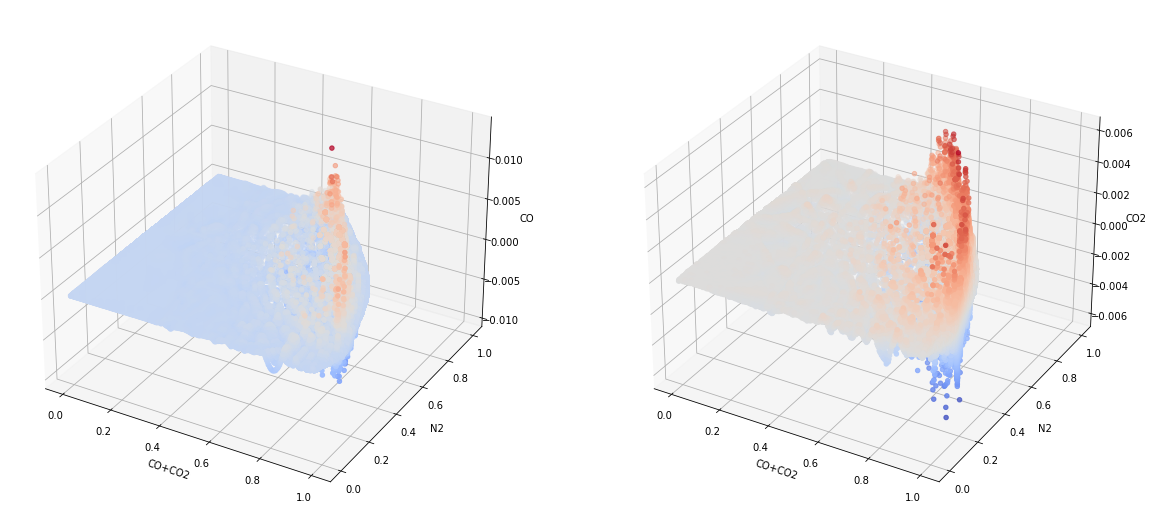

In [28]:
y_err = (y_pred-y).cpu().data.numpy()
plot_3d_subplot(x[:, :2].cpu().data.numpy(), y_err, f"result/3D_plot-ann1-CO_CO2-{token}-err-loss={mseLoss:.6f}.png")

In [29]:
std_err = np.abs(y_err).max(axis=0)

print(f"CO maximum norm err={std_err[0]}, CO2 maximum norm err={std_err[1]}")

CO maximum norm err=0.013279311201883304, CO2 maximum norm err=0.006001046493873258
